In [1]:
import sys
sys.path.append('../Utils')
sys.setrecursionlimit(10000)

import joblib
import pandas as pd
from sklearn import pipeline, preprocessing, metrics, model_selection, decomposition, cluster, compose
from scipy import stats
import numpy as np

import math

import matplotlib.pyplot as plt

%matplotlib inline

from utils import ReorderTransformer, LabelingTransformer, ClusterMultitree, AttentionTransformer

import sys
import os
import torch

import joblib

SEED = 42

In [2]:
DATASET_DIR = '../Dataset'
MODEL_DIR = '../Models/cluster_multitree'

## Dataset

In [3]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, 'n_train.csv'))
dev_df = pd.read_csv(os.path.join(DATASET_DIR, 'n_dev.csv'))

In [4]:
train_X, train_y = joblib.load(os.path.join(DATASET_DIR, 'attn_train.jl'))
dev_X, dev_y = joblib.load(os.path.join(DATASET_DIR, 'attn_dev.jl'))

In [5]:
X = np.concatenate((train_X, dev_X))
y = np.concatenate((train_y, dev_y))

In [6]:
df = pd.concat((train_df, dev_df))

In [7]:
train_indices = np.arange(0, train_X.shape[0])
dev_indices = np.arange(train_X.shape[0], train_X.shape[0] + dev_X.shape[0])

In [8]:
ds_info = joblib.load(os.path.join(DATASET_DIR, 'ds_info.jl'))

columns = ds_info['columns']
numerical_cols = ds_info['numerical_columns']
categorical_cols = ds_info['categorical_columns']
label_col = ds_info['target_column']

In [9]:
X = X.reshape(-1, (len(columns) - 1) ** 2)

## Grid search on number of clusters

### Visualization

In [10]:
pca = decomposition.PCA(n_components=2)
pca.fit(X[train_indices])
X_pca = pca.transform(X)

In [11]:
X_pca.shape

(45222, 2)

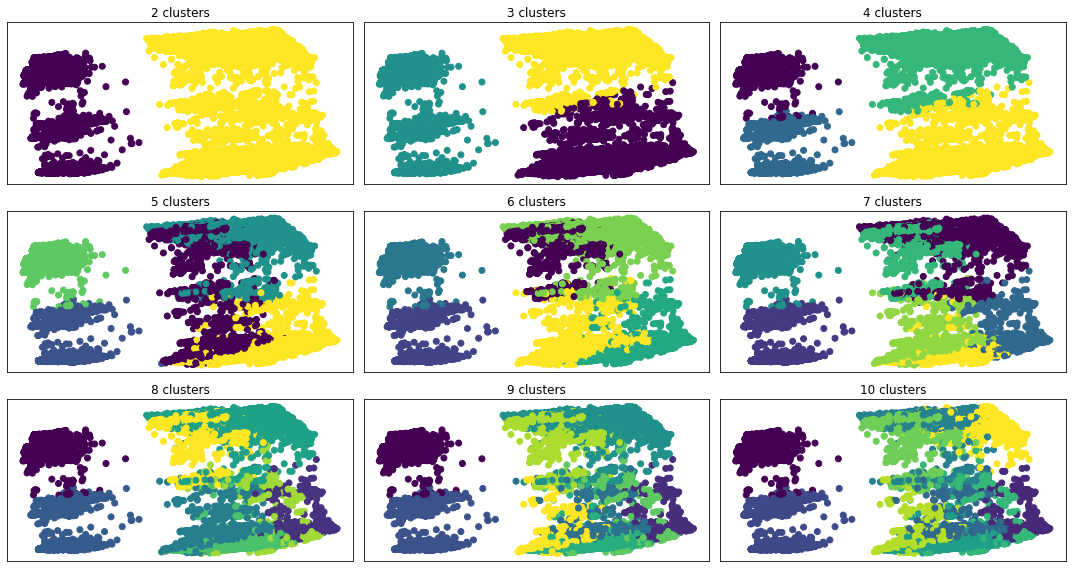

In [12]:
test_range = [i for i in range(2, 11)]

total_tests = len(test_range)
cols = 3
rows = math.ceil(total_tests / 3)


fig, axes = plt.subplots(rows, cols, figsize=(15, 8))

for row in range(rows):
    for col in range(cols):
        ax = axes[row, col]
        
        test_index = row * cols + col
        
        if test_index < len(test_range):
            n_clusters = test_range[test_index]

            kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=SEED)
            kmeans.fit(X[train_indices])
            y_clust = kmeans.predict(X[train_indices])

            ax.scatter(X_pca[train_indices, 0], X_pca[train_indices, 1], c=y_clust)
            ax.set_title('{} clusters'.format(n_clusters))
            
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

fig.tight_layout()
fig.savefig('Attention clustering.png')
plt.show()

### Processing original data

In [13]:
transformer = joblib.load('../Models/transformer_v4/transformer_v4_baseline.jl')

In [14]:
inp = transformer['preprocessing'].transform(train_df.drop(label_col, axis=1))

In [15]:
transformer['classifier'].module_

TransformerModelv4(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=25, out_features=25, bias=True)
        )
        (linear1): Linear(in_features=25, out_features=25, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=25, out_features=25, bias=True)
        (norm1): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (embedding): ModuleList(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): Linear(in_features=1, out_features=25, bias=True)
    (2): Linear(in_features=1, out_features=25, bias=True)
    (3): Linear(in_features=1, out_features=25, bias=True)
    (4): Linear(in_features=1, out_feat

In [16]:
categorical_transformer = pipeline.Pipeline(steps=[
        ('label', LabelingTransformer())])

numerical_transformer = pipeline.Pipeline(steps=[
        ('scaler', preprocessing.MinMaxScaler())
])

preprocessing_pipe = pipeline.Pipeline([
    ('reordering', ReorderTransformer(categorical_columns=categorical_cols, numerical_columns=numerical_cols)),
    ('columns_transformer', compose.ColumnTransformer(
        remainder='drop', 
        transformers=[
            ('categorical_transformer', categorical_transformer , categorical_cols),
            ('numerical_transformer', numerical_transformer , numerical_cols)
        ])
    )
])


pipe = pipeline.Pipeline([
    ('feature_concat', pipeline.FeatureUnion([
        ('original_data_preprocessing', preprocessing_pipe), 
        ('attention_extraction', AttentionTransformer('../Models/transformer_v4/transformer_v4_baseline.jl'))        
    ])),
    ('classifier', ClusterMultitree(n_features=len(columns) - 1, random_state=SEED))
])
    

In [17]:
param_grid = {
    'classifier__n_clusters': [x for x in range(2, 10, 2)],#[2 ** x for x in range(1, 11)],
    'classifier__max_depth': [x for x in range(1, 15)]
}

clf = model_selection.GridSearchCV(
    pipe,
    param_grid, 
    cv=((train_indices, dev_indices),),
    scoring='accuracy',
    refit=False,
    verbose=3,
)

clf = clf.fit(df.drop(label_col, axis=1), df[label_col])

Fitting 1 folds for each of 56 candidates, totalling 56 fits
[CV 1/1] END classifier__max_depth=1, classifier__n_clusters=2; total time=   4.7s
[CV 1/1] END classifier__max_depth=1, classifier__n_clusters=4; total time=   5.0s
[CV 1/1] END classifier__max_depth=1, classifier__n_clusters=6; total time=   6.0s
[CV 1/1] END classifier__max_depth=1, classifier__n_clusters=8; total time=   5.8s
[CV 1/1] END classifier__max_depth=2, classifier__n_clusters=2; total time=   4.9s
[CV 1/1] END classifier__max_depth=2, classifier__n_clusters=4; total time=   5.5s
[CV 1/1] END classifier__max_depth=2, classifier__n_clusters=6; total time=   5.8s
[CV 1/1] END classifier__max_depth=2, classifier__n_clusters=8; total time=   6.2s
[CV 1/1] END classifier__max_depth=3, classifier__n_clusters=2; total time=   4.7s
[CV 1/1] END classifier__max_depth=3, classifier__n_clusters=4; total time=   4.9s
[CV 1/1] END classifier__max_depth=3, classifier__n_clusters=6; total time=   5.7s
[CV 1/1] END classifier__m

In [18]:
clf.best_params_

{'classifier__max_depth': 8, 'classifier__n_clusters': 2}

In [19]:
pipe.set_params(**clf.best_params_)
_ = pipe.fit(train_df.drop(label_col, axis=1), train_df[label_col])

In [20]:
pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])

0.8601014370245139

In [21]:
pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])

0.8544

In [22]:
joblib.dump(pipe, os.path.join(MODEL_DIR, 'cluster_multitree_baseline.jl')) 

['../Models/cluster_multitree/cluster_multitree_baseline.jl']